In [36]:
# pip install cvxpy pandas matplotlib tqdm requests

In [37]:
import cvxpy as cp
import pandas as pd
import requests
from matplotlib import pyplot as plt
from tqdm import tqdm

In [38]:
time_from = pd.Timestamp("2026-02-24", tz="CET").floor("D")
time_to = time_from + pd.DateOffset(1)
idx = pd.date_range(start=time_from, end=time_to, freq="15min", inclusive="left")

In [39]:
# get day-ahead price (assume it is known)
time_from_str = time_from.tz_convert("UTC").strftime("%Y-%m-%dT%H:%M")
time_to_str = (time_to + pd.Timedelta("1h")).tz_convert("UTC").strftime("%Y-%m-%dT%H:%M")
price_area = "DK1"

url = f"https://api.energidataservice.dk/dataset/DayAheadPrices"
params = {
    "offset": 0,
    "start": time_from_str,
    "end": time_to_str,
}
res = requests.get(url, params=params)
res.raise_for_status()
price_df = pd.DataFrame(res.json().get("records")).query(f"PriceArea=='{price_area}'")
price_df.index = pd.to_datetime(price_df["TimeUTC"]).dt.tz_localize("UTC")
power_price = price_df["DayAheadPriceEUR"].astype(float).reindex(idx)

<Axes: >

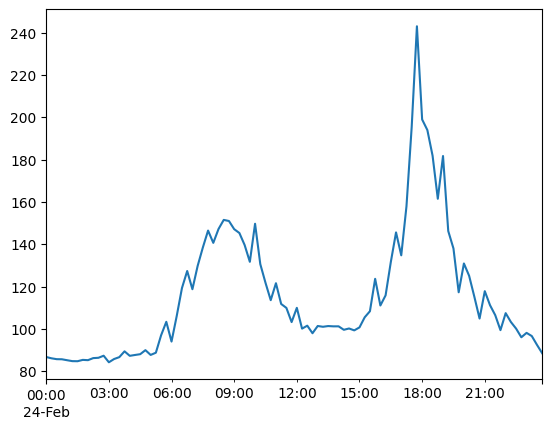

In [40]:
power_price.plot()

In [41]:
gb_eff = 0.98  # gas boiler heat efficiency
eb_eff = 0.98  # e-boiler heat efficiency
hp_cop = 4  # heat pump coefficient of performance
gas_price = 32  # EUR/MWht

heat_storage_capacity = 16800  # MWht

gb_capacity = 120  # MWt
hp_capacity = 80  # MWt
eb_capacity = 0  # MWt

<Axes: >

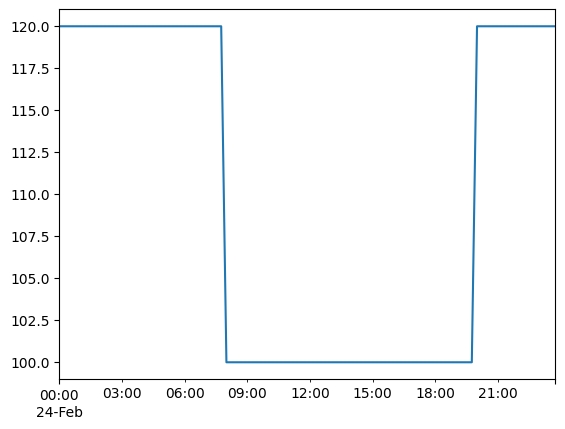

In [42]:
# heat demand is simulated to be higher during night time
heat_demand = pd.Series(100, index=idx)
heat_demand.loc[(heat_demand.index.hour >= 20) | (heat_demand.index.hour < 8)] = 120

heat_demand.plot()

In [43]:
# variables
hp_e_cons = cp.Variable(
    len(idx), name="hp_e_cons", nonneg=True
)  # heat pump electricity consumption
eb_e_cons = cp.Variable(
    len(idx), name="eb_e_cons", nonneg=True
)  # e boiler electricity consumption
gb_g_cons = cp.Variable(
    len(idx), name="gb_g_cons", nonneg=True
)  # gas boiler gas consumption

# parameters
up_regulation_cap = cp.Parameter(name="up_regulation_cap", value=0)
down_regulation_cap = cp.Parameter(name="down_regulation_cap", value=0)

# auxiliary variables
max_power_cons = hp_capacity / hp_cop + eb_capacity / eb_eff
total_e_cons = hp_e_cons + eb_e_cons
hp_h_prod = hp_e_cons * hp_cop
eb_h_prod = eb_eff * eb_e_cons
gb_h_prod = gb_eff * gb_g_cons
gas_cost = gas_price * gb_g_cons
power_cost = cp.multiply(power_price.values, hp_e_cons + eb_e_cons)
total_cost = power_cost + gas_cost

# constraints
constraints = [
    hp_h_prod + gb_h_prod + eb_h_prod == heat_demand.values,
    total_e_cons >= up_regulation_cap,
    max_power_cons - total_e_cons >= down_regulation_cap,
    hp_h_prod <= hp_capacity,
    gb_h_prod <= gb_capacity,
    eb_h_prod <= eb_capacity,
]

problem = cp.Problem(objective=cp.Minimize(cp.sum(total_cost)), constraints=constraints)
problem.solve()

np.float64(302782.9392023857)

In [44]:
up_reg_price = {}
down_reg_price = {}

up_regulation_cap.value = 0
for i in tqdm(range(int(max_power_cons))):
        down_regulation_cap.value = i
        problem.solve()
        if problem.status != "optimal":
            continue
        down_reg_price[i] = constraints[2].dual_value.round(4)

down_regulation_cap.value = 0
for i in tqdm(range(int(max_power_cons))):
        up_regulation_cap.value = i
        problem.solve()
        if problem.status != "optimal":
            continue
        up_reg_price[i] = constraints[1].dual_value.round(4)


up_reg_price = pd.DataFrame(up_reg_price, index=idx)
down_reg_price = pd.DataFrame(down_reg_price, index=idx)

100%|██████████| 20/20 [00:00<00:00, 428.39it/s]


<Axes: >

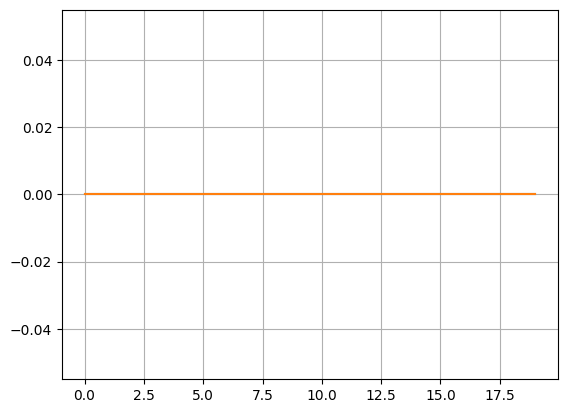

In [45]:
up_reg_price.iloc[0].plot(grid="on")
up_reg_price.iloc[48].plot(grid="on")

<Axes: >

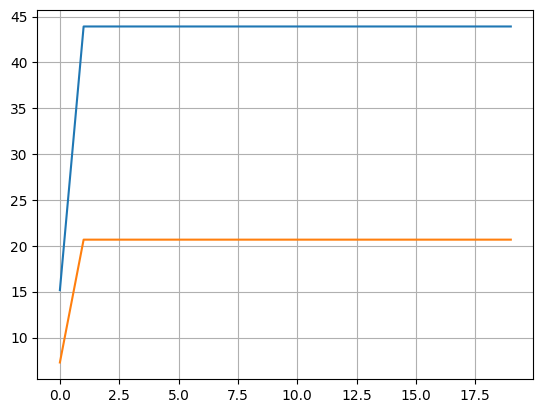

In [46]:
down_reg_price.iloc[0].plot(grid="on")
down_reg_price.iloc[48].plot(grid="on")

<Axes: >

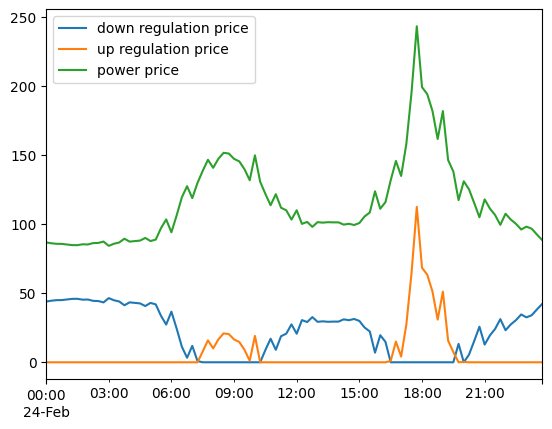

In [47]:
down_reg_price.iloc[:, -1].plot(label="down regulation price", legend=True)
up_reg_price.iloc[:, -1].plot(label="up regulation price", legend=True)
power_price.plot(label="power price", legend=True)